# Dependencies

In [1]:
from sys import path
path.append('src/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.preprocessing import LabelEncoder
from src.mrk_file import MRKFile
from src.iso_standard import PhotographicRequirements
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, Input

%matplotlib inline

Using TensorFlow backend.


In [2]:
FILE_TRAIN_DUMP = 'data/train_dump.pkl'
FILE_TRAIN_BOTTLENECKS = 'data/train_bottlenecks.pkl'

FILE_VAL_DUMP = 'data/val_dump.pkl'
FILE_VAL_BOTTLENECKS = 'data/val_bottlenecks.pkl'

INPUT_SHAPE = (224, 224, 3)

In [3]:
output_names = ['blurred', 
                'looking_away', 
                'ink_marked_creased', 
                'unnatural_skin_tone', 
                'too_dark_light', 
                'washed_out', 
                'pixelation', 
                'hair_across_eyes', 
                'eyes_closed', 
                'varied_background', 
                'roll_pitch_yaw', 
                'flash_reflection_on_skin', 
                'red_eyes', 
                'shadows_behind_head', 
                'shadows_across_face', 
                'dark_tinted_lenses', 
                'flash_reflection_on_lenses', 
                'frames_too_heavy', 
                'frame_covering_eyes', 
                'hat_cap', 
                'veil_over_face', 
                'mouth_open', 
                'presence_of_other_faces_or_toys']

# Helper Methods 

In [4]:
def history_to_dataframe(history, epoch=-1):
    loss_train = np.array([history[name + '_loss'][epoch] for name in output_names])
    loss_val = np.array([history['val_' + name + '_loss'][epoch] for name in output_names])
    acc_train = np.array([history[name + '_acc'][epoch] for name in output_names]) * 100
    acc_val = np.array([history['val_' + name + '_acc'][epoch] for name in output_names]) * 100

    data = np.concatenate(([loss_train], [loss_val], [acc_train], [acc_val]), axis=0).T
    return pd.DataFrame(data, columns=['loss_train', 'loss_val', 'acc_train', 'acc_val'], index=output_names)

def plot_history(history):
    from math import ceil

    n_graphs = len(output_names) * 2
    n_cols = 2
    n_rows = ceil(n_graphs / n_cols)

    plt.figure(figsize=(16, 100))
    for i, name in zip(range(1, n_graphs, 2), output_names):
        loss_train = history[name + '_loss']
        loss_val = history['val_' + name + '_loss']
        acc_train = history[name + '_acc']
        acc_val = history['val_' + name + '_acc']

        train_metrics = [loss_train, acc_train]
        val_metrics = [loss_val, acc_val]
        metrics = ['loss', 'acc']
        for sub, train, val, metric in zip([i, i + 1], train_metrics, val_metrics, metrics):
            plt.subplot(n_rows, n_cols, sub)
            plt.plot(train, label='train')
            plt.plot(val, label='val')
            plt.xlabel('epoch')
            plt.ylabel(metric)
            plt.title('{} ({})'.format(name, metric))
            plt.legend()
    plt.tight_layout()

# Load Data 

In [5]:
train_image_files, x_train, train_mrks = pkl.load(open(FILE_TRAIN_DUMP, 'rb'))

print(len(train_image_files), type(train_image_files))
print(x_train.shape, x_train.dtype)
print(len(train_mrks), type(train_mrks[0]))

5211 <class 'list'>
(5211, 224, 224, 3) float32
5211 <class 'src.mrk_file.MRKFile'>


In [6]:
val_image_files, x_val, val_mrks = pkl.load(open(FILE_VAL_DUMP, 'rb'))

print(len(val_image_files), type(val_image_files))
print(x_val.shape, x_val.dtype)
print(len(val_mrks), type(val_mrks[0]))

565 <class 'list'>
(565, 224, 224, 3) float32
565 <class 'src.mrk_file.MRKFile'>


# Save Bottlenecks 

In [7]:
base_model = MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

In [8]:
train_features = base_model.predict(x_train, batch_size=32, verbose=1)
val_features = base_model.predict(x_val, batch_size=32, verbose=1)

print(train_features.shape, train_features.dtype)
print(val_features.shape, val_features.dtype)

565/565 [==============================] - 1s 1ms/step
(5211, 7, 7, 1024) float32
(565, 7, 7, 1024) float32


In [9]:
train_values = np.array([mrk.photo_reqs.values() for mrk in train_mrks], dtype=np.int8)
val_values = np.array([mrk.photo_reqs.values() for mrk in val_mrks], dtype=np.int8)

print(train_values.shape, train_values.dtype)
print(val_values.shape, val_values.dtype)

(5211, 23) int8
(565, 23) int8


In [10]:
pkl.dump((train_features, train_values), open(FILE_TRAIN_BOTTLENECKS, 'wb'), protocol=-1)
pkl.dump((val_features, val_values), open(FILE_VAL_BOTTLENECKS, 'wb'), protocol=-1)

# Transfer Learning 

In [6]:
train_features, train_values = pkl.load(open(FILE_TRAIN_BOTTLENECKS, 'rb'))
val_features, val_values = pkl.load(open(FILE_VAL_BOTTLENECKS, 'rb'))

print(train_features.shape, train_features.dtype)
print(train_values.shape, train_values.dtype)
print(val_features.shape, val_features.dtype)
print(val_values.shape, val_values.dtype)

(5211, 7, 7, 1024) float32
(5211, 23) int8
(565, 7, 7, 1024) float32
(565, 23) int8


In [7]:
# encode reqs values from [-1, 0, 1] => [0, 1, 2]
enc = LabelEncoder()
enc.fit(train_values.ravel())

y_train = enc.transform(train_values.ravel()).reshape(train_values.shape)
y_val = enc.transform(val_values.ravel()).reshape(val_values.shape)

assert(y_train.shape == train_values.shape)
assert(y_val.shape == val_values.shape)
assert(np.all(y_train == train_values + 1))
assert(np.all(y_val == val_values + 1))

In [8]:
inputs = Input(shape=train_features.shape[1:], name='inputs')
avg_pool = GlobalAveragePooling2D()(inputs)

r2 = Dense(units=3, activation='softmax', name=output_names[0])(avg_pool)
r3 = Dense(units=3, activation='softmax', name=output_names[1])(avg_pool)
r4 = Dense(units=3, activation='softmax', name=output_names[2])(avg_pool)
r5 = Dense(units=3, activation='softmax', name=output_names[3])(avg_pool)
r6 = Dense(units=3, activation='softmax', name=output_names[4])(avg_pool)
r7 = Dense(units=3, activation='softmax', name=output_names[5])(avg_pool)
r8 = Dense(units=3, activation='softmax', name=output_names[6])(avg_pool)
r9 = Dense(units=3, activation='softmax', name=output_names[7])(avg_pool)
r10 = Dense(units=3, activation='softmax', name=output_names[8])(avg_pool)
r11 = Dense(units=3, activation='softmax', name=output_names[9])(avg_pool)
r12 = Dense(units=3, activation='softmax', name=output_names[10])(avg_pool)
r13 = Dense(units=3, activation='softmax', name=output_names[11])(avg_pool)
r14 = Dense(units=3, activation='softmax', name=output_names[12])(avg_pool)
r15 = Dense(units=3, activation='softmax', name=output_names[13])(avg_pool)
r16 = Dense(units=3, activation='softmax', name=output_names[14])(avg_pool)
r17 = Dense(units=3, activation='softmax', name=output_names[15])(avg_pool)
r18 = Dense(units=3, activation='softmax', name=output_names[16])(avg_pool)
r19 = Dense(units=3, activation='softmax', name=output_names[17])(avg_pool)
r20 = Dense(units=3, activation='softmax', name=output_names[18])(avg_pool)
r21 = Dense(units=3, activation='softmax', name=output_names[19])(avg_pool)
r22 = Dense(units=3, activation='softmax', name=output_names[20])(avg_pool)
r23 = Dense(units=3, activation='softmax', name=output_names[21])(avg_pool)
r24 = Dense(units=3, activation='softmax', name=output_names[22])(avg_pool)

model = Model(inputs=inputs, 
              outputs=[r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16, r17, r18, r19, r20, r21, r22, r23, r24], 
              name='icaonet')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 7, 7, 1024)   0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1024)         0           inputs[0][0]                     
__________________________________________________________________________________________________
blurred (Dense)                 (None, 3)            3075        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
looking_away (Dense)            (None, 3)            3075        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
ink_marked

Train on 5211 samples, validate on 565 samples
Epoch 1/5
5211/5211 [==============================] - 4s 726us/step - loss: 5.3900 - blurred_loss: 0.3069 - looking_away_loss: 0.5533 - ink_marked_creased_loss: 0.0764 - unnatural_skin_tone_loss: 0.1549 - too_dark_light_loss: 0.1410 - washed_out_loss: 0.0043 - pixelation_loss: 0.1959 - hair_across_eyes_loss: 0.1739 - eyes_closed_loss: 0.3797 - varied_background_loss: 0.1681 - roll_pitch_yaw_loss: 0.4892 - flash_reflection_on_skin_loss: 0.2774 - red_eyes_loss: 0.2891 - shadows_behind_head_loss: 0.4441 - shadows_across_face_loss: 0.2412 - dark_tinted_lenses_loss: 0.1355 - flash_reflection_on_lenses_loss: 0.2474 - frames_too_heavy_loss: 0.1613 - frame_covering_eyes_loss: 0.3230 - hat_cap_loss: 0.1536 - veil_over_face_loss: 0.0495 - mouth_open_loss: 0.4068 - presence_of_other_faces_or_toys_loss: 0.0175 - blurred_acc: 0.8881 - looking_away_acc: 0.7843 - ink_marked_creased_acc: 0.9681 - unnatural_skin_tone_acc: 0.9455 - too_dark_light_acc: 0.95

Epoch 4/5
5211/5211 [==============================] - 4s 717us/step - loss: 4.9600 - blurred_loss: 0.2821 - looking_away_loss: 0.5392 - ink_marked_creased_loss: 0.0676 - unnatural_skin_tone_loss: 0.1337 - too_dark_light_loss: 0.1179 - washed_out_loss: 0.0034 - pixelation_loss: 0.1845 - hair_across_eyes_loss: 0.1509 - eyes_closed_loss: 0.3559 - varied_background_loss: 0.1505 - roll_pitch_yaw_loss: 0.4748 - flash_reflection_on_skin_loss: 0.2548 - red_eyes_loss: 0.2761 - shadows_behind_head_loss: 0.4104 - shadows_across_face_loss: 0.2132 - dark_tinted_lenses_loss: 0.1213 - flash_reflection_on_lenses_loss: 0.2293 - frames_too_heavy_loss: 0.1440 - frame_covering_eyes_loss: 0.2864 - hat_cap_loss: 0.1291 - veil_over_face_loss: 0.0419 - mouth_open_loss: 0.3795 - presence_of_other_faces_or_toys_loss: 0.0137 - blurred_acc: 0.8981 - looking_away_acc: 0.7926 - ink_marked_creased_acc: 0.9724 - unnatural_skin_tone_acc: 0.9538 - too_dark_light_acc: 0.9589 - washed_out_acc: 0.9994 - pixelation_acc: 0

,loss_train,loss_val,acc_train,acc_val
blurred,0.306935,0.374689,88.812128,85.309735
looking_away,0.553296,0.681470,78.430244,78.407080
ink_marked_creased,0.076403,0.113916,96.814431,93.805310
unnatural_skin_tone,0.154860,1.500051,94.549990,71.504425
too_dark_light,0.141022,0.509886,95.413548,87.964602
washed_out,0.004318,0.755118,99.923239,93.982301
pixelation,0.195943,0.273263,93.571291,92.212389
hair_across_eyes,0.173906,0.673008,93.513721,91.504425
eyes_closed,0.379695,0.520672,86.605258,86.017699
varied_background,0.168068,1.031706,94.338898,82.654867


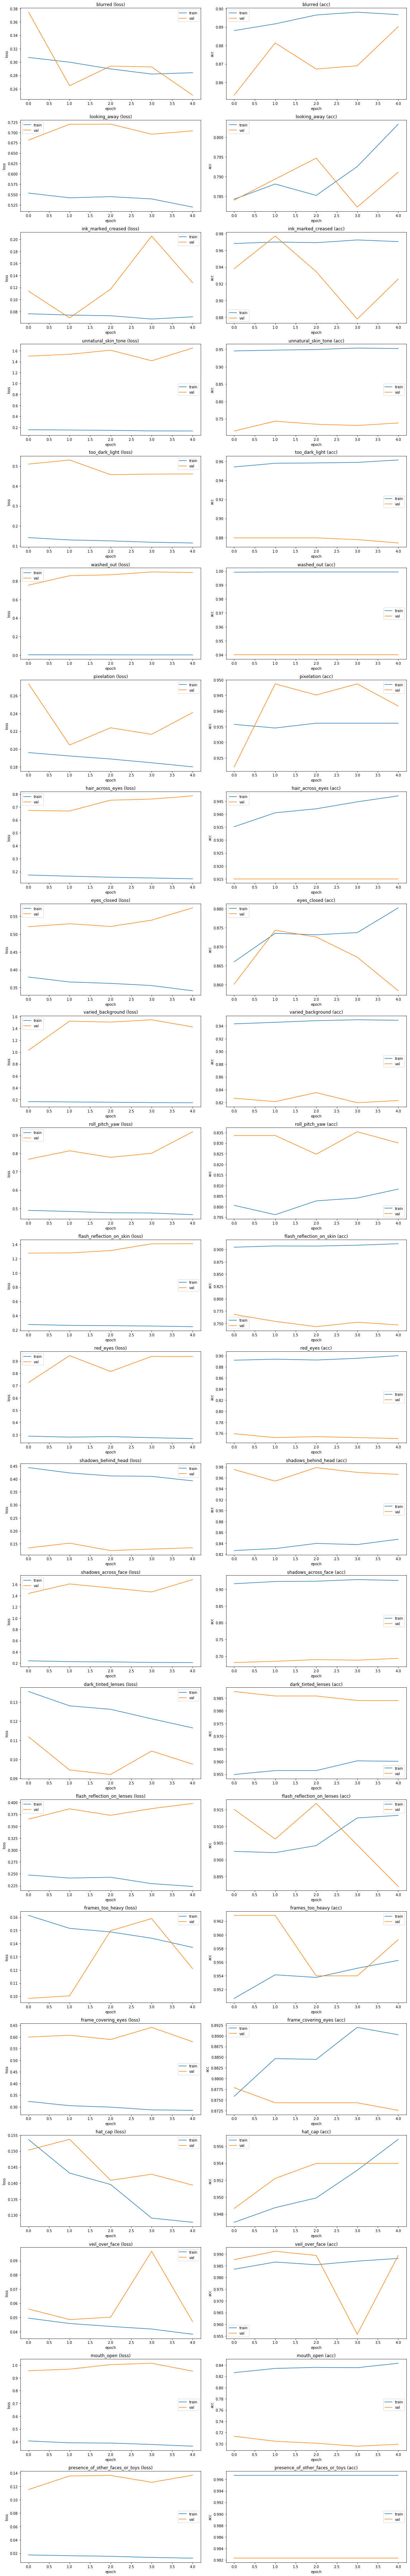

In [67]:
hist = model.fit(train_features, 
                 np.hsplit(y_train, range(1, y_train.shape[1])), 
                 batch_size=32, 
                 epochs=5, 
                 validation_data=(val_features, np.hsplit(y_val, range(1, y_val.shape[1]))))

plot_history(hist.history)
history_to_dataframe(hist.history, epoch=0)